In [51]:
import pandas as pd
import numpy as np
import pyproj
from scipy.spatial import KDTree
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

In [52]:
#read files
# transformed beetloader dataset
beetloader = pd.read_csv('../data/processed/beetloader_processed.csv')
# raw trucks dataset
trucks = pd.read_csv('../data/raw/trucks.csv')

In [53]:
beetloader.head()

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
0,2022-10-20 00:00:04.345,NaN,NaN,NaN,2.0,True,v0.0.01,98,98.0,51.001804,6.003630,10/20/2022,12:00:04 AM,0,0,4,20,10,2022
1,2022-10-20 00:00:13.874,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.001804,6.003629,10/20/2022,12:00:13 AM,0,0,13,20,10,2022
2,2022-10-20 00:00:33.896,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.001804,6.003629,10/20/2022,12:00:33 AM,0,0,33,20,10,2022
3,2022-10-20 00:00:44.415,NaN,NaN,NaN,1.0,True,v0.0.01,98,98.0,51.001804,6.003628,10/20/2022,12:00:44 AM,0,0,44,20,10,2022
4,2022-10-20 00:00:53.946,NaN,NaN,NaN,3.0,True,v0.0.01,98,98.0,51.001804,6.003628,10/20/2022,12:00:53 AM,0,0,53,20,10,2022


In [54]:
trucks.head()

,Unnamed: 0,A,B,C,Datum Erstwägung,Eingangswaagenzeit,GPS Längengrad,GPS Breitengrad
0,263,2.9,0.0,4.0,12/22/2022,7:22:16 AM,6.056932,50.998190
1,274,2.9,0.0,5.0,12/22/2022,6:31:34 AM,6.064783,50.999958
2,275,2.9,0.0,5.0,12/22/2022,6:13:24 AM,6.056932,50.998190
3,288,2.9,0.0,5.0,12/22/2022,4:57:12 AM,6.064783,50.999958
4,326,2.9,0.0,6.0,12/21/2022,10:11:13 PM,6.064783,50.999958


In [55]:
# drop unnamed column
trucks = trucks.drop(columns=['Unnamed: 0'])

In [56]:

# change column names
column_names = {
    'A': 'A',
    'B': 'B',
    'C': 'C',
    'Datum Erstwägung': 'date',
    'Eingangswaagenzeit': 'time',
    'GPS Längengrad': 'longitude',
    'GPS Breitengrad': 'latitude'
}
trucks = trucks.rename(columns=column_names)
# connect date and time columns
trucks['datetime'] = pd.to_datetime(trucks['date'] + ' ' + trucks['time'], format='%m/%d/%Y %I:%M:%S %p')

In [57]:
trucks = trucks.sort_values(by=['datetime'])
beetloader = beetloader.sort_values(by=['takenat'])

In [58]:
beetloader.head()

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
0,2022-10-20 00:00:04.345,NaN,NaN,NaN,2.0,True,v0.0.01,98,98.0,51.001804,6.003630,10/20/2022,12:00:04 AM,0,0,4,20,10,2022
1,2022-10-20 00:00:13.874,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.001804,6.003629,10/20/2022,12:00:13 AM,0,0,13,20,10,2022
2,2022-10-20 00:00:33.896,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.001804,6.003629,10/20/2022,12:00:33 AM,0,0,33,20,10,2022
3,2022-10-20 00:00:44.415,NaN,NaN,NaN,1.0,True,v0.0.01,98,98.0,51.001804,6.003628,10/20/2022,12:00:44 AM,0,0,44,20,10,2022
4,2022-10-20 00:00:53.946,NaN,NaN,NaN,3.0,True,v0.0.01,98,98.0,51.001804,6.003628,10/20/2022,12:00:53 AM,0,0,53,20,10,2022


## Problem: find observations from trucks and beetloader with the same date
<!--  -->

In [59]:
beetloader['takenat'] = pd.to_datetime(beetloader['takenat'], format='%Y-%m-%d %H:%M:%S')
print(beetloader['takenat'].dt.date.unique())
print(trucks['datetime'].dt.date.unique())


[datetime.date(2022, 10, 20) datetime.date(2022, 12, 6)
 datetime.date(2022, 12, 7)]
[datetime.date(2022, 9, 23) datetime.date(2022, 9, 24)
 datetime.date(2022, 9, 26) datetime.date(2022, 9, 29)
 datetime.date(2022, 10, 19) datetime.date(2022, 10, 20)
 datetime.date(2022, 10, 21) datetime.date(2022, 12, 6)
 datetime.date(2022, 12, 7) datetime.date(2022, 12, 10)
 datetime.date(2022, 12, 16) datetime.date(2022, 12, 21)
 datetime.date(2022, 12, 22)]


In [60]:
beetloader_dates = ['2022-10-20',  '2022-12-06', '2022-12-07', '2022-10-21'] #additional day after 20.10

In [61]:
trucks = trucks[trucks['datetime'].dt.strftime('%Y-%m-%d').isin(beetloader_dates)]

## Problem: find the trucks that are closest to the beetloader
### Steps to solve the problem:
#### 1. Visualize the gps data on map for both datasets to see if there is any overlap
#### 2. Calculate the distance between the gps coordinates of the trucks and beetloader for the identified overlap
#### 3. Create dataset with points that are within X meters of trucks gps_points
#### 4. Narrow down the results for a given day and gps point

## 1. Put gps coords on map

In [62]:
trucks.head()

,A,B,C,date,time,longitude,latitude,datetime
130,2.9,0.0,4.0,10/20/2022,6:18:21 AM,6.036406,51.009888,2022-10-20 06:18:21
129,2.9,0.0,4.0,10/20/2022,6:23:29 AM,6.036406,51.009888,2022-10-20 06:23:29
128,2.9,0.0,4.0,10/20/2022,7:13:39 AM,6.036406,51.009888,2022-10-20 07:13:39
127,2.9,0.0,4.0,10/20/2022,7:16:19 AM,6.036406,51.009888,2022-10-20 07:16:19
126,2.9,0.0,4.0,10/20/2022,7:16:48 AM,6.036406,51.009888,2022-10-20 07:16:48


In [63]:
trucks[['longitude', 'latitude']].value_counts()

longitude  latitude 
6.043033   51.005714    19
6.036406   51.009888     9
6.018067   51.017178     6
6.025018   51.011807     5
dtype: int64

In [64]:
beetloader[['latitude', 'longitude',]].drop_duplicates()[::15]

,latitude,longitude
0,51.001804,6.003630
29,50.998474,6.015807
69,50.998474,6.015793
116,50.998474,6.015774
149,50.998474,6.015758
...,...,...
18510,50.996944,5.964884
18532,50.996883,5.964707
18567,50.996880,5.964693
18601,51.005348,5.977183


In [66]:
# showing every 20th unique point from beetloader dataset, just to make it lighter, because there are too many points to smoothly work
# to see all points, just remove/change [::20] from the code below

import folium
m = folium.Map(location=[trucks['latitude'].mean(),trucks['longitude'].mean()], zoom_start=15)


for idx, row in trucks.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=f"Index: {idx}, DateTime: {row['datetime']}, A: {row['A']}, B: {row['B']}, C: {row['C']}"
    ).add_to(m)
    # Add a circle of radius 200 meters around the point
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=250,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.2,
    ).add_to(m)

for idx, row in beetloader[['latitude', 'longitude','takenat']].drop_duplicates()[::20].iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color="red"),
        tooltip=f"Index: {idx}, DateTime: {row['takenat']}"
    ).add_to(m)
    
m


In [17]:
# cheking distance[m] between two points, index taken from the map above
point_truck = (trucks.loc[117, 'latitude'], trucks.loc[117, 'longitude'])
point_beetloader = (beetloader.loc[635, 'latitude'], beetloader.loc[635, 'longitude'])
geod = pyproj.Geod(ellps="WGS84")
angle1, angle2, distance = geod.inv(point_truck[1], point_truck[0], point_beetloader[1], point_beetloader[0])
distance


134.62033151550762

##### For provided trucks dataset and beetloader dataset distance in no more than 200m

#### Use kdtree to find points in range below 200 m

In [18]:
trucks_coords = trucks[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values

tree = KDTree(trucks_coords)

In [19]:
beetloader_points = beetloader[['latitude', 'longitude']].values
points_found = tree.query_ball_point(beetloader_points, 0.002)  
beetloader_trucks = beetloader[[bool(i) for i in points_found]]

In [20]:
beetloader_trucks

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
402,2022-10-20 03:33:46.573,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:46 AM,3,33,46,20,10,2022
403,2022-10-20 03:33:56.074,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:56 AM,3,33,56,20,10,2022
404,2022-10-20 03:34:06.615,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:06 AM,3,34,6,20,10,2022
405,2022-10-20 03:34:16.099,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:16 AM,3,34,16,20,10,2022
406,2022-10-20 03:34:26.623,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036484,10/20/2022,03:34:26 AM,3,34,26,20,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,2022-12-07 05:01:18.811,NaN,NaN,NaN,0.0,True,v0.0.14,99,99.0,51.016609,6.017304,12/07/2022,05:01:18 AM,5,1,18,7,12,2022
12551,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.14,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12552,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.19,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12553,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.17,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022


In [21]:
# showing every 20th unique point from beetloader dataset, just to make it lighter, because there are too many points to smoothly work
# to see all points, just remove/change [::20] from the code below

import folium
m = folium.Map(location=[beetloader_trucks['latitude'].mean(),beetloader_trucks['longitude'].mean()], zoom_start=15)


for idx, row in trucks.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        tooltip=f"Index: {idx}, DateTime: {row['datetime']}, A: {row['A']}, B: {row['B']}, C: {row['C']}"
    ).add_to(m)

for idx, row in beetloader_trucks[['latitude', 'longitude','takenat']].drop_duplicates().iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color="red"),
        tooltip=f"Index: {idx}, DateTime: {row['takenat']}"
    ).add_to(m)


m


##### Basic eda on found points

In [22]:
beetloader_trucks 

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
402,2022-10-20 03:33:46.573,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:46 AM,3,33,46,20,10,2022
403,2022-10-20 03:33:56.074,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:56 AM,3,33,56,20,10,2022
404,2022-10-20 03:34:06.615,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:06 AM,3,34,6,20,10,2022
405,2022-10-20 03:34:16.099,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:16 AM,3,34,16,20,10,2022
406,2022-10-20 03:34:26.623,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036484,10/20/2022,03:34:26 AM,3,34,26,20,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,2022-12-07 05:01:18.811,NaN,NaN,NaN,0.0,True,v0.0.14,99,99.0,51.016609,6.017304,12/07/2022,05:01:18 AM,5,1,18,7,12,2022
12551,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.14,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12552,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.19,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12553,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.17,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022


In [23]:
beetloader_trucks['takenat'].dt.date.unique()
# dates match trucks dates

array([datetime.date(2022, 10, 20), datetime.date(2022, 12, 6),
       datetime.date(2022, 12, 7)], dtype=object)

In [24]:
beetloader_trucks['algorithmversion'].value_counts()
# small sample size for v0.0.08,
# resonable size for v0.0.14 and v0.0.17,
# good for v0.0.1 and v0.0.19

v0.0.01    706
v0.0.19    472
v0.0.14    101
v0.0.17    101
v0.0.08     25
Name: algorithmversion, dtype: int64

In [25]:
beetloader_trucks.factory.value_counts()

98    976
99    429
Name: factory, dtype: int64

In [26]:
beetloader_trucks.streamid.value_counts()

98.0    976
99.0    429
Name: streamid, dtype: int64

#### Lets see how many observations we have in each day / hour

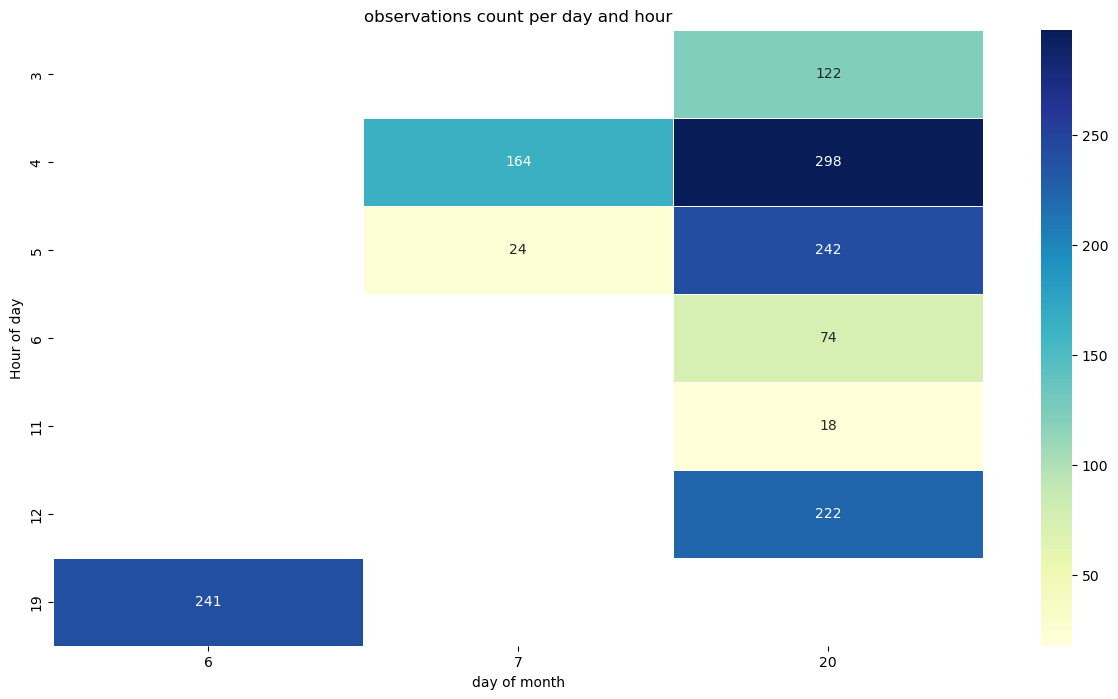

In [27]:
# get day and hour from takenat
beetloader_trucks['day'] = beetloader_trucks['takenat'].dt.day
beetloader_trucks['hour'] = beetloader_trucks['takenat'].dt.hour
heatmap_data = beetloader_trucks.pivot_table(index='hour', columns='day', values='takenat', aggfunc='count')

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title('observations count per day and hour')
plt.xlabel('day of month')
plt.ylabel('Hour of day')
plt.show()

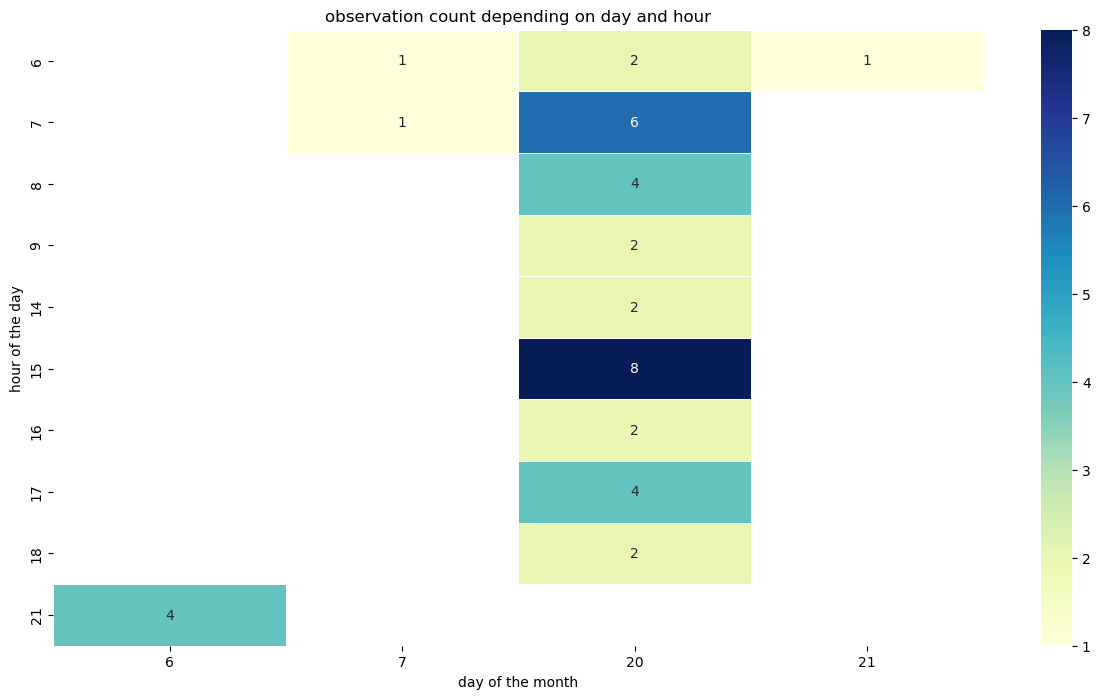

In [28]:
# Wyciągnięcie dni i godzin z kolumny 'takenat'
trucks['day'] = trucks['datetime'].dt.day
trucks['hour'] = trucks['datetime'].dt.hour

# Tworzenie tabeli przestawnej z liczbą wpisów dla każdego dnia i godziny
heatmap_data = trucks.pivot_table(index='hour', columns='day', values='datetime', aggfunc='count')

# Wizualizacja heatmapy
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5)
plt.title('observation count depending on day and hour')
plt.xlabel('day of the month')
plt.ylabel('hour of the day')
plt.show()


In [29]:
beetloader_trucks['takenat'].dt.date.value_counts() 

2022-10-20    976
2022-12-06    241
2022-12-07    188
Name: takenat, dtype: int64

In [30]:
trucks['datetime'].dt.date.value_counts()

2022-10-20    32
2022-12-06     4
2022-12-07     2
2022-10-21     1
Name: datetime, dtype: int64

In [31]:
trucks[trucks['datetime'].dt.date == pd.to_datetime('2022-10-20')]

,A,B,C,date,time,longitude,latitude,datetime,day,hour
130,2.9,0.0,4.00,10/20/2022,6:18:21 AM,6.036406,51.009888,2022-10-20 06:18:21,20,6
129,2.9,0.0,4.00,10/20/2022,6:23:29 AM,6.036406,51.009888,2022-10-20 06:23:29,20,6
128,2.9,0.0,4.00,10/20/2022,7:13:39 AM,6.036406,51.009888,2022-10-20 07:13:39,20,7
127,2.9,0.0,4.00,10/20/2022,7:16:19 AM,6.036406,51.009888,2022-10-20 07:16:19,20,7
126,2.9,0.0,4.00,10/20/2022,7:16:48 AM,6.036406,51.009888,2022-10-20 07:16:48,20,7
125,2.9,0.0,4.00,10/20/2022,7:23:44 AM,6.036406,51.009888,2022-10-20 07:23:44,20,7
124,2.9,0.0,4.00,10/20/2022,7:30:24 AM,6.036406,51.009888,2022-10-20 07:30:24,20,7
123,2.9,0.0,4.00,10/20/2022,7:53:17 AM,6.036406,51.009888,2022-10-20 07:53:17,20,7
122,2.9,0.0,4.00,10/20/2022,8:05:58 AM,6.025018,51.011807,2022-10-20 08:05:58,20,8
121,2.9,0.0,4.00,10/20/2022,8:12:05 AM,6.025018,51.011807,2022-10-20 08:12:05,20,8


In [32]:
trucks[trucks['datetime'].dt.date == pd.to_datetime('2022-10-21')]


,A,B,C,date,time,longitude,latitude,datetime,day,hour
98,2.9,1.0,4.0,10/21/2022,6:16:19 AM,6.043033,51.005714,2022-10-21 06:16:19,21,6


Lost delivery from 20.10.2022? Rest of trucks from this gps_coords are from 20.10.2022, maybe car broke down? Also no beetloader data for this day and point

In [33]:
trucks[['A', 'B', 'C']].describe()

,A,B,C
count,3.900000e+01,39.000000,39.000000
mean,2.900000e+00,0.025641,4.590000
std,1.799578e-15,0.160128,0.779072
min,2.900000e+00,0.000000,4.000000
25%,2.900000e+00,0.000000,4.000000
50%,2.900000e+00,0.000000,4.000000
75%,2.900000e+00,0.000000,5.000000
max,2.900000e+00,1.000000,6.000000


In [34]:
trucks['A'].value_counts()

2.9    39
Name: A, dtype: int64

In [35]:
trucks['B'].value_counts()

0.0    38
1.0     1
Name: B, dtype: int64

In [36]:
trucks['C'].value_counts()

4.00    22
5.00     8
6.00     7
4.25     1
4.76     1
Name: C, dtype: int64

Data for all selected deliveries are very similar, there is not much deviation 

### Checking loadings for deliveries from one location

In [37]:
trucks[['latitude', 'longitude']].value_counts()

latitude   longitude
51.005714  6.043033     19
51.009888  6.036406      9
51.017178  6.018067      6
51.011807  6.025018      5
dtype: int64

In [38]:
lat = 51.017178
lng = 6.018067

In [39]:
trucks_point = trucks[(trucks['latitude'] == lat) & (trucks['longitude'] == lng)]

In [40]:
beetloader_trucks

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
402,2022-10-20 03:33:46.573,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:46 AM,3,33,46,20,10,2022
403,2022-10-20 03:33:56.074,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:33:56 AM,3,33,56,20,10,2022
404,2022-10-20 03:34:06.615,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:06 AM,3,34,6,20,10,2022
405,2022-10-20 03:34:16.099,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036483,10/20/2022,03:34:16 AM,3,34,16,20,10,2022
406,2022-10-20 03:34:26.623,NaN,NaN,NaN,0.0,True,v0.0.01,98,98.0,51.010075,6.036484,10/20/2022,03:34:26 AM,3,34,26,20,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12548,2022-12-07 05:01:18.811,NaN,NaN,NaN,0.0,True,v0.0.14,99,99.0,51.016609,6.017304,12/07/2022,05:01:18 AM,5,1,18,7,12,2022
12551,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.14,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12552,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.19,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022
12553,2022-12-07 05:02:08.351,NaN,NaN,NaN,1.0,True,v0.0.17,99,99.0,51.016609,6.017303,12/07/2022,05:02:08 AM,5,2,8,7,12,2022


In [41]:
# Haversine formula to calculate distance between two latitude longitude points
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371000
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance


lat = 51.017178
lng = 6.018067


filtered_rows = beetloader_trucks[beetloader_trucks.apply(lambda row: haversine_distance(lat, lng, row['latitude'], row['longitude']) <= 200, axis=1)]


In [42]:

filtered_rows.algorithmversion.value_counts()

v0.0.19    101
v0.0.14    101
v0.0.01    101
v0.0.17    101
v0.0.08     25
Name: algorithmversion, dtype: int64

In [43]:
filtered_rows.groupby('algorithmversion')['takenat'].agg(['min', 'max'])

,min,max
algorithmversion,,
v0.0.01,2022-12-06 19:17:06.714,2022-12-07 05:02:08.351
v0.0.08,2022-12-06 19:19:36.852,2022-12-07 04:56:48.033
v0.0.14,2022-12-06 19:17:06.714,2022-12-07 05:02:08.351
v0.0.17,2022-12-06 19:17:06.714,2022-12-07 05:02:08.351
v0.0.19,2022-12-06 19:17:06.714,2022-12-07 05:02:08.351


Exluding v0.0.08 algorithmversion, lookslike every model was used to evaluate loadings.

In [44]:
trucks_point

,A,B,C,date,time,longitude,latitude,datetime,day,hour
97,2.9,0.0,6.0,12/6/2022,9:04:46 PM,6.018067,51.017178,2022-12-06 21:04:46,6,21
96,2.9,0.0,6.0,12/6/2022,9:06:38 PM,6.018067,51.017178,2022-12-06 21:06:38,6,21
95,2.9,0.0,6.0,12/6/2022,9:16:34 PM,6.018067,51.017178,2022-12-06 21:16:34,6,21
94,2.9,0.0,6.0,12/6/2022,9:48:55 PM,6.018067,51.017178,2022-12-06 21:48:55,6,21
93,2.9,0.0,4.0,12/7/2022,6:30:46 AM,6.018067,51.017178,2022-12-07 06:30:46,7,6
92,2.9,0.0,4.0,12/7/2022,7:03:59 AM,6.018067,51.017178,2022-12-07 07:03:59,7,7


Lets look on algorithm v0.0.01, day 6.12

In [45]:
alg_v1 = filtered_rows[(filtered_rows['algorithmversion'] == 'v0.0.01') & (filtered_rows['day'] == 6)]

In [46]:
trucks_point[trucks_point['day'] == 6][['A', 'B', 'C']].describe()

,A,B,C
count,4.0,4.0,4.0
mean,2.9,0.0,6.0
std,0.0,0.0,0.0
min,2.9,0.0,6.0
25%,2.9,0.0,6.0
50%,2.9,0.0,6.0
75%,2.9,0.0,6.0
max,2.9,0.0,6.0


In [47]:
alg_v1[['beetloader_A', 'beetloader_B', 'beetloader_C']].describe()

,beetloader_A,beetloader_B,beetloader_C
count,49.000000,49.000000,49.00000
mean,3.043878,0.692857,3.89898
std,0.165489,0.357322,0.27400
min,2.650000,0.120000,3.21000
25%,2.910000,0.460000,3.73000
50%,3.030000,0.680000,3.86000
75%,3.130000,0.930000,4.12000
max,3.520000,1.580000,4.45000


In [48]:
alg_v19 = filtered_rows[(filtered_rows['algorithmversion'] == 'v0.0.19') & (filtered_rows['day'] == 6)]

In [49]:
alg_v19[['beetloader_A', 'beetloader_B', 'beetloader_C']].describe()

,beetloader_A,beetloader_B,beetloader_C
count,49.000000,49.000000,49.00000
mean,3.043878,0.692857,3.89898
std,0.165489,0.357322,0.27400
min,2.650000,0.120000,3.21000
25%,2.910000,0.460000,3.73000
50%,3.030000,0.680000,3.86000
75%,3.130000,0.930000,4.12000
max,3.520000,1.580000,4.45000


In [50]:
filtered_rows[filtered_rows['day'] == 6].head(20)

,takenat,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,beetloader_empty_belt,algorithmversion,factory,streamid,latitude,longitude,date,time,hour,minute,seconds,day,month,year
10926,2022-12-06 19:17:06.714,NaN,NaN,NaN,0.0,True,v0.0.19,99,99.0,51.016762,6.017495,12/06/2022,07:17:06 PM,19,17,6,6,12,2022
10927,2022-12-06 19:17:06.714,NaN,NaN,NaN,0.0,True,v0.0.14,99,99.0,51.016762,6.017495,12/06/2022,07:17:06 PM,19,17,6,6,12,2022
10928,2022-12-06 19:17:06.714,NaN,NaN,NaN,0.0,True,v0.0.01,99,99.0,51.016762,6.017495,12/06/2022,07:17:06 PM,19,17,6,6,12,2022
10929,2022-12-06 19:17:06.714,NaN,NaN,NaN,0.0,True,v0.0.17,99,99.0,51.016762,6.017495,12/06/2022,07:17:06 PM,19,17,6,6,12,2022
10933,2022-12-06 19:17:16.223,NaN,NaN,NaN,0.0,True,v0.0.19,99,99.0,51.016762,6.017495,12/06/2022,07:17:16 PM,19,17,16,6,12,2022
10932,2022-12-06 19:17:16.223,NaN,NaN,NaN,0.0,True,v0.0.17,99,99.0,51.016762,6.017495,12/06/2022,07:17:16 PM,19,17,16,6,12,2022
10930,2022-12-06 19:17:16.223,NaN,NaN,NaN,0.0,True,v0.0.01,99,99.0,51.016762,6.017495,12/06/2022,07:17:16 PM,19,17,16,6,12,2022
10931,2022-12-06 19:17:16.223,NaN,NaN,NaN,0.0,True,v0.0.14,99,99.0,51.016762,6.017495,12/06/2022,07:17:16 PM,19,17,16,6,12,2022
10935,2022-12-06 19:17:26.756,NaN,NaN,NaN,0.0,True,v0.0.17,99,99.0,51.016762,6.017495,12/06/2022,07:17:26 PM,19,17,26,6,12,2022
10936,2022-12-06 19:17:26.756,NaN,NaN,NaN,0.0,True,v0.0.19,99,99.0,51.016762,6.017495,12/06/2022,07:17:26 PM,19,17,26,6,12,2022
